## IBM Data Science Coursera Capstone Project Jupyter Notebook

Author: Mark Hanson

#### Background
This Jupyter notebook will be used for the final capstone project in the Coursera IBM Data Science Professional class.  In brief the requirements are to leverage Foursquare location data to explore or compare any choosen neighborhoods or cities or to come up with a problem that can be soloved with data obtained with the Foursquare API. Unfortunately, Foursquare timeseries data is only available to verified managers of Foursquare venues which makes answering some more interesting questions more difficult.

#### Description of my capstone project
For my capstone project I have choosen to cluster the cities in the Minneapolis / Saint Paul 7 county metropolitan area similar to what was done in the labs.  However, in addition to using Foursquare data, I downloaded real estate value data from Zillow and plan to use this to add more detail for the clustering algorithm.  As I get into the analysis I may change or expand the scope or objective of the project by identifying a specific question to answer or adding some more analysis.

Data attribution (sources):
1. Home value data attribution: “Data acquired from Zillow.com/data on April 10, 2019. Aggregated data on this page is made freely available by Zillow for non-commercial use.”
2. Zip code centroid data attribution:
Dataset Identifier: us-zip-code-latitude-and-longitude
License: Creative Commons Attribution-ShareAlike
Modified: February 9, 2018 10:31 AM
Publisher: CivicSpace Labs
Reference: https://boutell.com/zipcodes/
Attributions: Copyright 2004 CivicSpace Labs
Last processing:
February 9, 2018 10:39 AM (metadata)
February 9, 2018 10:39 AM (data)
3. Zip code GeoJSON attributions: https://www.census.gov/cgi-bin/geo/shapefiles2010/layers.cgi & https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/README.md

Changes / additions under consideration:
  Plot a choropleth style map of clusters to better visualize the entire zipcode vs just the bubble marker - When plotting geoJSON subset found counties scattered all over state. Also cluster map seems to leave off many metro area cities / zipcodes - cluster fix started - Hennepin county was misspelled.
  Create a choropleth style heat map of median home prices by zipcode
  Calculate year over year percent change in median home value by zipcode to show which are increasing vs decreasing in value
  
1. Add income by zipcode information - difficult to process from available data
2. Analysis, regression, prediction of median home price change -  Modify df to add year over year % change in median home value
2. Crime rates - not interested in this data
3. Academic achievement - not interested in this data

## Install and import packages

In [1]:
# Install geocoder package with conda
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#print('geopy installed!')

In [2]:
# install folium
#!conda install -c conda-forge folium=0.5.0 --yes
#print('folium installed!')

In [3]:
#from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [1]:
# import other modules
import pandas as pd
from pandas.io.json import json_normalize

import numpy as np
import requests
import json
import bs4
from bs4 import BeautifulSoup as bs

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
import folium

**Week 1 assignment**

In [3]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


## Import Zillow data
**NOTE: While working on project, skip down to section MP 3 and import zill_MSP_data.csv or zill_MSP_data_test.csv instead of recreating entire df.**

Create a new dataframe with Minneapolis / St. Paul 7 county metro area, drop unused columns, rename ZipCode, and reset index

In [130]:
zill_MNWI_df = pd.read_csv('Zillow_Home_Value_Index_MN_WI.csv')
zill_MN_df = zill_MNWI_df[zill_MNWI_df['State']=='MN']

In [149]:
#zill_MN_df[zill_MN_df['CountyName']=='Hennepin County']

In [150]:
zill_MSP_df = zill_MN_df[zill_MN_df['CountyName'].isin(['Anoka County','Carver County','Dakota County','Hennepin County','Ramsey County','Washington County'])]

In [151]:
zill_MSP_df.shape

(134, 282)

In [152]:
zill_MSP_df = zill_MSP_df.drop(['RegionID'], axis=1)
zill_MSP_df = zill_MSP_df.drop(zill_MSP_df.columns.to_series()['1996-04':'2013-12'], axis=1)
zill_MSP_df = zill_MSP_df.rename(index=str, columns={'RegionName':'ZipCode'})
zill_MSP_df.reset_index(drop=True, inplace=True)

## Import Zip Code Centroid Geocoordinates

Notes about geocoordinates
Originally created an empty dataframe then looped through all the cities in the MSP dataframe and added the latitude and longitude data to the new df using geolocator.  Unfortunately, geolocator uses city and state to get latitude and longitude which results in the same information for all the zip codes in a larger city. This is a problem since the home value data is broken down to the finer granularity of zip code.

Found dataset on OpenDataSoft (Civic Space Labs) that links zip code to single geolocation (not boundries as with geoJSON). Used API to get data but could only get 100 records and then got an error which could be a quota limit problem. Not comfortable creating login information since not familiar with site and since data is available for download as csv anyway.  Downloaded and saved as csv

In [156]:
# get geocoordinates for a point in each zipcode
MSP_ZipCode_Geo = pd.read_csv('us-zip-code-latitude-and-longitude.csv', sep=';')
MSP_ZipCode_Geo.drop(columns=['Timezone','Daylight savings time flag', 'geopoint'], inplace=True)
MSP_ZipCode_Geo = MSP_ZipCode_Geo[MSP_ZipCode_Geo['State'].isin(['MN'])]
MSP_ZipCode_Geo.rename(columns={'Zip':'ZipCode'}, inplace=True)
#MSP_ZipCode_Geo.set_index('ZipCode', inplace=True)
#MSP_ZipCode_Geo[MSP_ZipCode_Geo['ZipCode']==55123]
MSP_ZipCode_Geo.shape

(1054, 5)

Merge MSP_ZipCode_Lat_Long df into zill_MSP_df and reoder columns so latitude and longitude are after city and state

In [154]:
# merge geocoordinates by zipcode into home value df
zill_MSP_df = pd.merge(zill_MSP_df, MSP_ZipCode_Geo, on=['ZipCode'])

In [155]:
zill_MSP_df.shape

(133, 72)

In [9]:
# drop city and state from MSP_ZipCode_Geo as they are less specific that those from zill_MSP_df
zill_MSP_df.drop(columns=['City_y','State_y'], inplace=True)
zill_MSP_df.rename(columns={'City_x' : 'City', 'State_x' : 'State'}, inplace=True)

In [10]:
# move geocoordinates from end columns to right after city name
cols = zill_MSP_df.columns.tolist()
cols = cols[0:2] + cols[-2:] + cols[2:-2]
zill_MSP_df = zill_MSP_df[cols]

In [13]:
# write zill_MSP_df to csv so don't have to recreate it everytime using slow geolocator
zill_MSP_df.to_csv(path_or_buf='zill_MSP_data.csv')

## Load cleaned data set from CSV
While working on project, import zill_MSP_data.csv to df instead of re-creating it each time.

**Work with full dataset**

In [11]:
zill_MSP_df = pd.read_csv('zill_MSP_data.csv')
zill_MSP_df = zill_MSP_df.drop(columns=['Unnamed: 0'])

**Work with test dataset**

In [15]:
#zill_MSP_df = pd.read_csv('zill_MSP_data_test.csv')
#zill_MSP_df = zill_MSP_df.drop(columns=['Unnamed: 0'])

How may zipcodes in say St. Paul?

In [7]:
#zill_MSP_df[zill_MSP_df['City']=='Saint Paul']

Original data set had 12 zip codes in St. Paul all with the same geolocation. Venue data uses that geolocation so all of St. Paul would have the same venues regardless of zip code.  Zillow home value data has data for each zip code.  This mismatch would have obscured the relationship between home values and venues resulting in poor classifications.

By getting geolocations for each zip code online the mismatch is resolved and each zip code can have an associated list of venues around it.  Originally had issues with rural locations having no venues (too small a radius) and urban locations being classified together due to too large a radius so experimented with radius and eliminating rural areas by limiting to 7 county metro area. Ultimately selected a 1.61km (1mi) radius around each zip code geolocation and ran query during business hours.

## Get Venue data on individual geocoordinate

Set this code block aside for now; used for exporing venues individually rather than in a loop

In [157]:
# Four square credentials

In [13]:
# st paul 55012 geoloc
lat = 44.9537
lng = -93.0900

# other locations to explore
#lat = zill_MSP_df.iloc[50,2]
#lng = zill_MSP_df.iloc[50,3]

In [142]:
# set radius to 1610 m and limit search to 100 venues; Check to see if all zipcodes have venues and drop those that don't
radius = 1610
LIMIT =100

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limmit={}'.format(
    CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, radius, LIMIT)
#url

In [39]:
results = requests.get(url).json()

In [40]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [41]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Tamarack Materials,Hardware Store,45.326197,-93.288753


In [42]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

1 venues were returned by Foursquare.


End of code block to set aside for now

## Explore Cities in the 7 county Minneapolis-St.Paul metropolitan area

Let's create a function to repeat the same process to all the cities in the Minneapolis-St.Paul metro area

In [14]:
# set radius to 1610m (approx 1 mi) and limit search to 100 venues; Check to see if all zipcodes have venues and drop those that don't
radius = 1610
LIMIT = 100

In [15]:
def getNearbyVenues(zipcode, names, latitudes, longitudes):
    
    venues_list=[]
    for zipcode, name, lat, lng in zip(zipcode, names, latitudes, longitudes):
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # deal with case where rural zipcodes are bigger and venues might not be found within 2km so increase to 5km
#        if results == []:
#            rad = 5000
        
        # return only relevant information for each nearby venue                
        venues_list.append([(
            zipcode,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZipCode','City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called MSP_venues.

In [18]:
MSP_venues = getNearbyVenues(zipcode = zill_MSP_df['ZipCode'], names = zill_MSP_df['City'], latitudes = zill_MSP_df['Latitude'], longitudes = zill_MSP_df['Longitude'])

Notice that slightly different geocoordinates exist for city and venue

While working on project, import MSP_venues.csv to df instead of re-creating it each time.

In [19]:
# write MSP_venues df to csv so don't have to recreate it everytime also time dependent last run and saved 8:13AM 4/24/19
#MSP_venues.to_csv(path_or_buf='MSP_venues_data.csv')

In [12]:
# read MSP_venues df from csv so don't have to run as many queries against Foursquare
MSP_venues = pd.read_csv('MSP_venues_data.csv')
MSP_venues = MSP_venues.drop(columns=['Unnamed: 0'])
print(MSP_venues.shape)
MSP_venues.head()

(2178, 8)


,ZipCode,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,55124,Apple Valley,44.743963,-93.20624,Five Guys,44.735794,-93.216446,Burger Joint
1,55124,Apple Valley,44.743963,-93.20624,Satay 2 Go,44.731270,-93.201148,Asian Restaurant
2,55124,Apple Valley,44.743963,-93.20624,Kwik Trip,44.739600,-93.218739,Convenience Store
3,55124,Apple Valley,44.743963,-93.20624,Cole's Salon,44.731770,-93.216405,Salon / Barbershop
4,55124,Apple Valley,44.743963,-93.20624,Jimmy John's,44.733264,-93.206591,Sandwich Place


In [13]:
print('There are {} uniques categories.'.format(len(MSP_venues['Venue Category'].unique())))

There are 291 uniques categories.


## Analyze Each Neighborhood

In [14]:
# one hot encoding
MSP_onehot = pd.get_dummies(MSP_venues[['Venue Category']], prefix="", prefix_sep="")

# add city column back to dataframe
MSP_onehot['ZipCode'] = MSP_venues['ZipCode'] 

# move city column to the first column
fixed_columns = [MSP_onehot.columns[-1]] + list(MSP_onehot.columns[:-1])
MSP_onehot = MSP_onehot[fixed_columns]

#MSP_onehot.head()

In [15]:
MSP_onehot.shape

(2178, 292)

In [16]:
# list the average number of venues of each type in each zipcode
MSP_grouped = MSP_onehot.groupby('ZipCode').mean().reset_index()
#MSP_grouped.head()

Troubleshooting: Find the zipcodes that are in zill_MSP_df that are missing in MSP_grouped

In [17]:
MSP_ZipCode_List = MSP_grouped['ZipCode'].tolist()
MSP_ZipCode_List.sort()
MSP_ZipCode_List[0:5]
len(MSP_ZipCode_List)

72

In [18]:
zill_ZipCode_List = zill_MSP_df['ZipCode'].tolist()
zill_ZipCode_List.sort()
zill_ZipCode_List[0:5]
len(zill_ZipCode_List)

72

In [19]:
missing_zipcode = []

for x in zill_ZipCode_List:
    if x not in MSP_ZipCode_List:
#        print('zill: ', x)
        missing_zipcode.append(x)
missing_zipcode

[]

In [20]:
zill_MSP_df[zill_MSP_df['ZipCode'].isin(missing_zipcode)]
# filter out WI earlier up in analysis!

,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,2014-01,2014-02,...,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02


Function to sort the venues in descending order.

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood.

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['ZipCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['ZipCode'] = MSP_grouped['ZipCode']

for ind in np.arange(MSP_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(MSP_grouped.iloc[ind, :], num_top_venues)

#city_venues_sorted.head()

In [23]:
city_venues_sorted.shape

(72, 11)

In [24]:
city_venues_sorted.head()

,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,55001,Athletics & Sports,Zoo Exhibit,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish Market,Fondue Restaurant
1,55003,Bakery,Comfort Food Restaurant,BBQ Joint,New American Restaurant,Harbor / Marina,Park,Athletics & Sports,Video Store,Bar,Breakfast Spot
2,55005,Sandwich Place,Gas Station,Business Service,Zoo Exhibit,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service
3,55011,Hardware Store,Zoo Exhibit,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish Market,Flower Shop
4,55014,American Restaurant,Pizza Place,Fast Food Restaurant,Fondue Restaurant,Video Store,Thrift / Vintage Store,Bar,Grocery Store,Big Box Store,Massage Studio


## Cluster Cities from venues and Feb 2019 median home value data sets

Create MSP_med_HV df with latest median home value for each zipcode

In [25]:
# keep first 2 columns and last column from zill_MSP_df in new median home value df
cols1 = zill_MSP_df.columns.tolist()
cols1 = cols1[0:2] + cols1[-1:]    # + cols1[3:-2]
MSP_med_HV = zill_MSP_df[cols1]
#MSP_med_HV.head()

In [26]:
# join home value from feb 2019 with grouped venue by zipcode data
MSP_grouped_HV_clustering = MSP_grouped
MSP_grouped_HV_clustering = MSP_grouped_HV_clustering.join(MSP_med_HV.set_index('ZipCode'), on='ZipCode')
#MSP_grouped_HV_clustering.head()

In [27]:
# after joining with median home value df move median home value to first column
cols2 = MSP_grouped_HV_clustering.columns.tolist()
cols2 = cols2[-1:] + cols2[1:-2] #+ cols2[:] # + cols2[-1:] + cols2[1:-2]
#cols2
MSP_grouped_HV_clustering = MSP_grouped_HV_clustering[cols2]
#MSP_grouped_HV_clustering.head()

Begin clustering and identify optimum number of clusters. This data set has home value and venues together before clustering

Rename home value column and normalize it

Normalize home value data so that clusters take into account venue data. Pick feature range for home value scaling such that it is given more weight which is both meaningful - as home value is likely most important - and also produces a knee to enable to select an appropriate k (number of clusters).

In [28]:
MSP_grouped_HV_clustering.rename(columns={'2019-02':'Feb-2019 Median Home Value'}, inplace=True)

In [29]:
# create df with normalized home values in range between 1 and 100
MSP_grouped_HV_Norm_clustering = MSP_grouped_HV_clustering
scaler = MinMaxScaler(feature_range=(1,100))
MSP_grouped_HV_Norm_clustering.iloc[:,0:1] = scaler.fit_transform(MSP_grouped_HV_Norm_clustering['Feb-2019 Median Home Value'].values.reshape(-1,1))

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [30]:
MSP_grouped_HV_Norm_clustering.shape

(72, 292)

In [31]:
MSP_grouped_HV_Norm_clustering.head()

,Feb-2019 Median Home Value,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Art Gallery,...,Warehouse Store,Water Park,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,97.684211,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23.749226,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26.099071,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,32.842105,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,29.027864,0.0,0.0,0.0,0.0,0.052632,0.157895,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Evaluate k- means accuracy
Evaluate and graph accuracy - as measured by inertia - with various values of k (number of clusters) and select the k value at or around the knee point. 
    external approach - compare clusters with ground truth, if available
    internal approach - average of the distance between data points within a cluster and average of the distances of data points from their cluster centroids.
    Calculate and graph the accuracy (i.e. error) as the mean distance of data points from their cluster centroid

In [26]:
# set number of clusters as range from 1 to 72 where 72 clusters would be one for each zipcode
kclusters = range(1,72)
k_inertia = []
k_val = []
unity_start = []   # array position where clusters start to contain only 1 zipcode

# run k-means clustering
for k in kclusters:
    kmeans = KMeans(init = "k-means++", n_clusters=k, random_state=0).fit(MSP_grouped_HV_Norm_clustering)
    k_val.append(k)
    k_inertia.append(kmeans.inertia_)
    
# find where first cluster with only one entry starts
    cluster_density = pd.Series(kmeans.labels_).value_counts()
    i = 0
    first_one = 0
    for elem in cluster_density:
        if elem != 1:
            i+=1
        else:
            first_one = i
    unity_start.append(first_one)

In [27]:
unistart = []
eff_ratio = []

for i, j in zip(k_val,unity_start):
    unistart.append(j)
    eff_ratio.append(j/i)
#k_minus_unistart[34:36]
#eff_ratio[0:12]
#del k_inertia
#del k_val

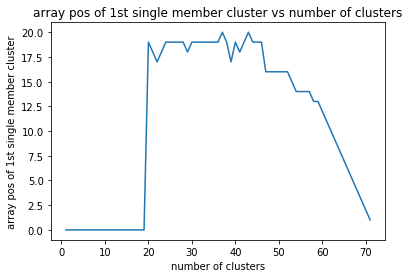

In [28]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(6, 4))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# plot k-means inertia (to be minimized) vs number of clusters k. Select knee point in graph
ax.plot(k_val, unistart)

# Title of the plot
ax.set_title('array pos of 1st single member cluster vs number of clusters')

ax.set_xlabel('number of clusters')
ax.set_ylabel('array pos of 1st single member cluster')
#ax.set_xlim([15,20])
#ax.set_ylim([-1,40])

plt.show()

In [39]:
unistart[7:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19]

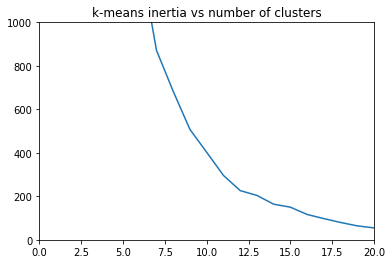

In [29]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(6, 4))

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# plot k-means inertia (to be minimized) vs number of clusters k. Select knee point in graph
ax.plot(k_val, k_inertia)

# Title of the plot
ax.set_title('k-means inertia vs number of clusters')
ax.set_ylim(bottom=0, top=1000)
ax.set_xlim(left=0, right=20)

plt.show()

In [37]:
k_inertia[7:20]

[682.4182370155906,
 507.20569003197147,
 402.22502982682386,
 296.0477330705472,
 226.26591168306726,
 204.0402436311206,
 163.77524174479043,
 149.9263756915577,
 116.39033181223829,
 97.43908687986938,
 79.64232604915458,
 64.00414295749908,
 54.782197904755805]

In [69]:
kmeans.labels_

array([0, 6, 6, 8, 8, 1, 6, 1, 0, 6, 3, 4, 1, 8, 4, 4, 3, 4, 4, 7, 3, 4,
       2, 4, 3, 2, 2, 8, 6, 3, 4, 4, 1, 1, 3, 7, 1, 1, 8, 6, 5, 1, 6],
      dtype=int32)

## After selecting number of clusters, re-run k-means

In [32]:
kclusters = 10
kmeans = KMeans(init = "k-means++", n_clusters=kclusters, random_state=0).fit(MSP_grouped_HV_Norm_clustering)

In [34]:
cluster_density = pd.Series(kmeans.labels_).value_counts()
#cluster_density

## Create Merged Dataset for Cluster Map
So now that we have the data and the KMeans model initialized, let's plot them and see what it looks like!

In [35]:
# select basic info and feb 2019 home value data columns from zill_MSP_df to merge with venue data
cols3 = zill_MSP_df.columns.tolist()
cols3 = cols3[0:8] + cols3[-1:]
#cols3

In [36]:
# create MSP_merged as seed for merging with venues data
MSP_merged = zill_MSP_df[cols3]

In [37]:
# give feb 2019 home value data a more descriptive name
MSP_merged.rename(columns={'2019-02':'Feb-2019 Median Home Value'}, inplace=True)

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [130]:
#MSP_merged['Feb-2019 Median Home Value'] = MSP_merged['Feb-2019 Median Home Value'].apply(lambda x: "${:.0f}K".format((x/1000)))

In [470]:
# drop clustering labels
#city_venues_sorted.drop(columns=['Cluster Labels'], inplace=True)

In [467]:
# add clustering labels
#city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [38]:
# merge home value by zipcode and geocoordinates with venue data
MSP_merged = MSP_merged.join(city_venues_sorted.set_index('ZipCode'), on='ZipCode')

In [39]:
MSP_merged.insert(0,'Cluster Labels', kmeans.labels_)

In [86]:
#MSP_merged['Cluster Labels'].value_counts()

In [40]:
MSP_merged.head()

,Cluster Labels,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,Feb-2019 Median Home Value,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,8,55124,Apple Valley,44.743963,-93.20624,MN,Minneapolis-St. Paul-Bloomington,Dakota County,472,276800,Park,Coffee Shop,Asian Restaurant,Gym / Fitness Center,Convenience Store,Soccer Field,American Restaurant,Pizza Place,Mexican Restaurant,Mobile Phone Shop
1,7,55044,Lakeville,44.669564,-93.26654,MN,Minneapolis-St. Paul-Bloomington,Dakota County,779,352000,Department Store,Beach,Skating Rink,Disc Golf,Golf Course,Doctor's Office,Lake,Harbor / Marina,Zoo Exhibit,Financial or Legal Service
2,7,55337,Burnsville,44.770297,-93.27302,MN,Minneapolis-St. Paul-Bloomington,Dakota County,806,273500,Coffee Shop,Video Store,Home Service,Sandwich Place,Salon / Barbershop,Pizza Place,Hotel,Lighting Store,Music Venue,General Entertainment
3,2,55106,Saint Paul,44.967565,-93.05001,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,841,185600,Mexican Restaurant,Grocery Store,Asian Restaurant,Park,Pizza Place,Gym,Sandwich Place,Chinese Restaurant,Fast Food Restaurant,Pharmacy
4,2,55303,Ramsey,45.247509,-93.41800,MN,Minneapolis-St. Paul-Bloomington,Anoka County,850,255200,Convenience Store,Construction & Landscaping,Campground,Home Service,Playground,Dog Run,Zoo Exhibit,Flower Shop,Farm,Farmers Market


## Create Cluster Map

Set latitude and longitude for St. Paul

In [41]:
# set st. paul as map starting point
latitude = 44.9537
longitude = -93.0900
#print(latitude, longitude)

In [42]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, city, poi, med_hv, cluster in zip(MSP_merged['Latitude'], MSP_merged['Longitude'], MSP_merged['City'], MSP_merged['ZipCode'], MSP_merged['Feb-2019 Median Home Value'], MSP_merged['Cluster Labels']):
#    fancy_label = ' Cluster: ' + str(cluster) + '<br>' + 'City: ' + str(city) + '<br>' + 'Zipcode: ' + str(poi) +'<br>' + ' Feb-2019 Median Home Value: ' + '${:,.0f}'.format(med_hv)
    fancy_label = ' Cluster: ' + str(cluster) + '<br>' + 'City: ' + str(city) + '<br>' + 'Zipcode: ' + str(poi) +'<br>' + ' Feb-2019 Median Home Value: ' + '${:,.0f}K'.format(med_hv/1000)
    iframe = folium.IFrame(html=fancy_label, width=300, height=90)
    label = folium.Popup(iframe, max_width=2650, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

Examine each cluster and determine the discriminating median home value and venue categories that distinguish each cluster. Based on the defining categories, assign a name to each cluster.

#### Cluster 0

In [43]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 0, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

,Cluster Labels,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,Feb-2019 Median Home Value,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,0,55122,Eagan,44.804548,-93.19871,MN,Minneapolis-St. Paul-Bloomington,Dakota County,2506,273700,Pizza Place,Coffee Shop,Grocery Store,Gym,ATM,Auto Garage,Salon / Barbershop,Big Box Store,Supplement Shop,Shipping Store
18,0,55118,West Saint Paul,44.903165,-93.10026,MN,Minneapolis-St. Paul-Bloomington,Dakota County,2933,260900,Chinese Restaurant,Pizza Place,American Restaurant,Supplement Shop,Middle Eastern Restaurant,Miscellaneous Shop,Soccer Field,Flower Shop,Skating Rink,Shoe Store
19,0,55016,Cottage Grove,44.830966,-92.93739,MN,Minneapolis-St. Paul-Bloomington,Washington County,3041,259600,Pizza Place,Sandwich Place,Trail,Hotel,Optical Shop,Mexican Restaurant,Skating Rink,Supermarket,Fast Food Restaurant,Liquor Store
21,0,55116,Saint Paul,44.913815,-93.17459,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,3156,342700,Coffee Shop,Pizza Place,American Restaurant,Chinese Restaurant,Sandwich Place,Pharmacy,Video Store,Liquor Store,Mobile Phone Shop,Park
22,0,55128,Oakdale,44.985792,-92.96532,MN,Minneapolis-St. Paul-Bloomington,Washington County,3297,252800,Park,Sandwich Place,Bowling Alley,Road,Liquor Store,Video Store,Salon / Barbershop,Bridal Shop,American Restaurant,Lounge
25,0,55434,Blaine,45.164248,-93.25310,MN,Minneapolis-St. Paul-Bloomington,Anoka County,3438,233900,Sandwich Place,Pharmacy,Video Store,Pizza Place,Mobile Phone Shop,Fast Food Restaurant,Spa,Chinese Restaurant,Salon / Barbershop,Coffee Shop
27,0,55126,Shoreview,45.085643,-93.13530,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,3811,300400,Grocery Store,Lake,ATM,Pizza Place,Pharmacy,Pub,Park,Coffee Shop,Sandwich Place,Chinese Restaurant
32,0,55102,Saint Paul,44.935315,-93.12049,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,4334,228900,American Restaurant,Italian Restaurant,Bar,Coffee Shop,Café,Southern / Soul Food Restaurant,Park,Pizza Place,Mexican Restaurant,Liquor Store
39,0,55038,Hugo,45.161267,-92.99596,MN,Minneapolis-St. Paul-Bloomington,Washington County,5494,301200,Liquor Store,ATM,Pizza Place,Sandwich Place,Coffee Shop,Restaurant,Grocery Store,American Restaurant,Business Service,Fondue Restaurant
41,0,55127,Vadnais Heights,45.076708,-93.08280,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,6024,327000,Baseball Field,Park,Video Store,Golf Course,Trail,Lake,Lawyer,Fondue Restaurant,Flower Shop,Fish Market


{'whiskers': [<matplotlib.lines.Line2D at 0x7f66d6730dd8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f66d67302e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f66d6730a20>],
 'medians': [<matplotlib.lines.Line2D at 0x7f66d67240b8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f66d6724e80>],
 'means': []}

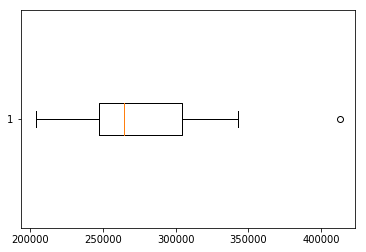

In [44]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 0, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 1

In [45]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 1, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

,Cluster Labels,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,Feb-2019 Median Home Value,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,1,55082,Stillwater,45.054551,-92.82581,MN,Minneapolis-St. Paul-Bloomington,Washington County,2120,360900,Bed & Breakfast,American Restaurant,Park,Wine Bar,Bar,Candy Store,Pizza Place,Ice Cream Shop,Hotel,Sporting Goods Shop
20,1,55421,Columbia Heights,45.050434,-93.25007,MN,Minneapolis-St. Paul-Bloomington,Anoka County,3146,214900,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Park,Discount Store,Indian Restaurant,Grocery Store,Thai Restaurant,Sandwich Place,Coffee Shop
38,1,55075,South Saint Paul,44.887966,-93.04546,MN,Minneapolis-St. Paul-Bloomington,Dakota County,5374,214900,Restaurant,Coffee Shop,Sandwich Place,Bar,Convenience Store,Burger Joint,Grocery Store,Liquor Store,General Travel,Bowling Alley
45,1,55387,Waconia,44.849912,-93.78514,MN,Minneapolis-St. Paul-Bloomington,Carver County,7558,309100,Coffee Shop,Pizza Place,American Restaurant,Sandwich Place,Park,Bowling Alley,Bar,Discount Store,Movie Theater,Gift Shop
55,1,55388,Watertown,44.955136,-93.84467,MN,Minneapolis-St. Paul-Bloomington,Carver County,11036,258700,Restaurant,Italian Restaurant,Grocery Store,Sandwich Place,River,Liquor Store,Pharmacy,Baseball Field,Breakfast Spot,American Restaurant


{'whiskers': [<matplotlib.lines.Line2D at 0x7f66d6709ac8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f66d6709550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f66d6709eb8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f66d6706470>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f66d6706208>],
 'means': []}

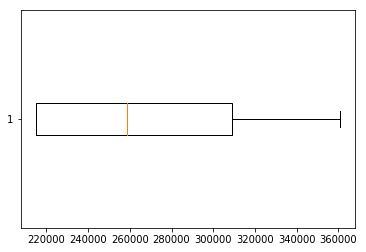

In [46]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 1, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 2

In [47]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 2, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

,Cluster Labels,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,Feb-2019 Median Home Value,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,2,55106,Saint Paul,44.967565,-93.05001,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,841,185600,Mexican Restaurant,Grocery Store,Asian Restaurant,Park,Pizza Place,Gym,Sandwich Place,Chinese Restaurant,Fast Food Restaurant,Pharmacy
4,2,55303,Ramsey,45.247509,-93.41800,MN,Minneapolis-St. Paul-Bloomington,Anoka County,850,255200,Convenience Store,Construction & Landscaping,Campground,Home Service,Playground,Dog Run,Zoo Exhibit,Flower Shop,Farm,Farmers Market
6,2,55104,Saint Paul,44.953665,-93.15922,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,955,234800,Coffee Shop,Thrift / Vintage Store,Fast Food Restaurant,Pizza Place,Park,Breakfast Spot,Gym / Fitness Center,Bookstore,Korean Restaurant,Grocery Store
17,2,55432,Fridley,45.095674,-93.25336,MN,Minneapolis-St. Paul-Bloomington,Anoka County,2824,227300,Park,Bar,American Restaurant,Gym,Fast Food Restaurant,Check Cashing Service,Optical Shop,Grocery Store,Coffee Shop,Trail
34,2,55025,Forest Lake,45.272117,-92.99110,MN,Minneapolis-St. Paul-Bloomington,Washington County,4530,291700,Fast Food Restaurant,Sandwich Place,Pizza Place,Coffee Shop,Pet Store,Hotel,Thrift / Vintage Store,Big Box Store,Burger Joint,Burrito Place
35,2,55123,Eagan,44.804048,-93.13378,MN,Minneapolis-St. Paul-Bloomington,Dakota County,4624,339000,Baseball Field,Pizza Place,Video Store,Pharmacy,Photography Studio,Salon / Barbershop,Tennis Court,Tex-Mex Restaurant,Nail Salon,Restaurant
44,2,55107,Saint Paul,44.928315,-93.08876,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,7297,192400,Harbor / Marina,Park,Mexican Restaurant,American Restaurant,Bar,Café,Coffee Shop,Gas Station,Scenic Lookout,Boat or Ferry
46,2,55103,Saint Paul,44.964115,-93.12261,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,7763,185700,Vietnamese Restaurant,Grocery Store,Bakery,Thai Restaurant,BBQ Joint,Asian Restaurant,Mexican Restaurant,Liquor Store,Park,Pizza Place
59,2,55005,East Bethel,45.395494,-93.23584,MN,Minneapolis-St. Paul-Bloomington,Anoka County,12002,259300,Sandwich Place,Gas Station,Business Service,Zoo Exhibit,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service
60,2,55043,Lakeland,44.931600,-92.77001,MN,Minneapolis-St. Paul-Bloomington,Washington County,12426,261300,Gym,Convenience Store,Gas Station,Beach,Beach Bar,Sandwich Place,Bar,Zoo Exhibit,Fish Market,Farmers Market


{'whiskers': [<matplotlib.lines.Line2D at 0x7f66d676de80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f66d676d278>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f66d676d6d8>],
 'medians': [<matplotlib.lines.Line2D at 0x7f66d676a8d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f66d676a240>],
 'means': []}

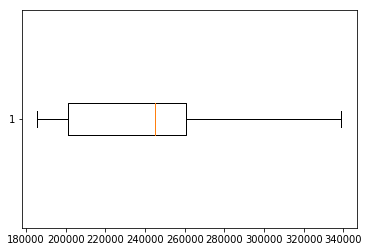

In [48]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 2, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 3

In [49]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 3, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

,Cluster Labels,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,Feb-2019 Median Home Value,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,3,55433,Coon Rapids,45.163848,-93.31950,MN,Minneapolis-St. Paul-Bloomington,Anoka County,2489,229500,Pizza Place,Soccer Field,Rental Car Location,Bar,Chinese Restaurant,Candy Store,Pharmacy,Baseball Field,Brewery,Home Service
23,3,55024,Farmington,44.649263,-93.15222,MN,Minneapolis-St. Paul-Bloomington,Dakota County,3311,278900,Pizza Place,Fast Food Restaurant,Pub,Gym / Fitness Center,Skating Rink,Mexican Restaurant,Steakhouse,Brewery,Bowling Alley,Sandwich Place
51,3,55115,Mahtomedi,45.060048,-92.95762,MN,Minneapolis-St. Paul-Bloomington,Washington County,9340,364800,Steakhouse,Bar,Pizza Place,Convenience Store,Dive Bar,Coffee Shop,Food,Soccer Field,Spa,Beach
62,3,55073,Scandia,45.275771,-92.83001,MN,Minneapolis-St. Paul-Bloomington,Washington County,12796,350300,Tree,Lake,Farm,Food,Zoo Exhibit,Fish Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Financial or Legal Service


{'whiskers': [<matplotlib.lines.Line2D at 0x7f66d674d0b8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f66d674b5f8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f66d674d588>],
 'medians': [<matplotlib.lines.Line2D at 0x7f66d674b470>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f66d6747a58>],
 'means': []}

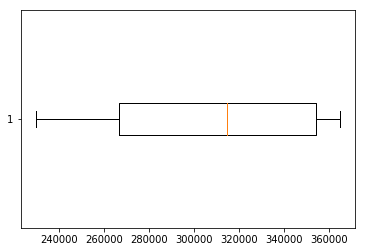

In [50]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 3, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 4

In [51]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 4, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

,Cluster Labels,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,Feb-2019 Median Home Value,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,4,55105,Saint Paul,44.934465,-93.16554,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,3678,363700,Bakery,Coffee Shop,Pizza Place,Breakfast Spot,Bookstore,Ice Cream Shop,Bar,Playground,Grocery Store,Arts & Crafts Store
29,4,55449,Blaine,45.168287,-93.20001,MN,Minneapolis-St. Paul-Bloomington,Anoka County,3940,328600,Video Store,Soccer Field,Gift Shop,Electronics Store,Sandwich Place,Gas Station,Pet Store,Pharmacy,Golf Course,Business Service
30,4,55318,Chaska,44.809954,-93.61050,MN,Minneapolis-St. Paul-Bloomington,Carver County,3955,297600,Baseball Field,Park,Sandwich Place,Optical Shop,Video Store,Scenic Lookout,Spa,Middle School,Playground,Hockey Arena
61,4,55055,Newport,44.871166,-93.00187,MN,Minneapolis-St. Paul-Bloomington,Washington County,12475,225400,Pharmacy,Sandwich Place,Monument / Landmark,Diner,Rental Car Location,Pizza Place,Food,Italian Restaurant,Dive Bar,Fast Food Restaurant


{'whiskers': [<matplotlib.lines.Line2D at 0x7f66d583e630>,
 'caps': [<matplotlib.lines.Line2D at 0x7f66d583ecc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f66d583e4e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f66d5847390>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f66d58476d8>],
 'means': []}

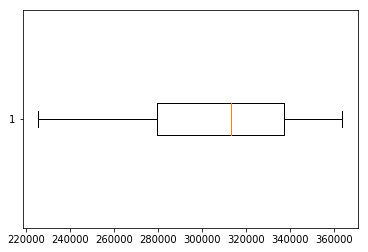

In [52]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 4, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 5

In [53]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 5, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

,Cluster Labels,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,Feb-2019 Median Home Value,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,5,55125,Woodbury,44.921982,-92.94234,MN,Minneapolis-St. Paul-Bloomington,Washington County,1317,315200,Sandwich Place,Pizza Place,Coffee Shop,Park,American Restaurant,Pharmacy,Shipping Store,Mexican Restaurant,Chinese Restaurant,Furniture / Home Store
47,5,55077,Inver Grove Heights,44.825391,-93.06893,MN,Minneapolis-St. Paul-Bloomington,Dakota County,7772,407200,Gym,Coffee Shop,Event Space,Skating Rink,Farm,Outdoors & Recreation,Fondue Restaurant,Flower Shop,Fish Market,Financial or Legal Service
49,5,55042,Lake Elmo,44.999023,-92.90939,MN,Minneapolis-St. Paul-Bloomington,Washington County,8877,476300,Business Service,Park,Construction & Landscaping,Food,Flower Shop,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish Market
53,5,55070,Saint Francis,45.395912,-93.37005,MN,Minneapolis-St. Paul-Bloomington,Anoka County,9906,227600,Fast Food Restaurant,Pizza Place,Sporting Goods Shop,Chinese Restaurant,Bar,Sandwich Place,Salon / Barbershop,Gym / Fitness Center,Park,Pharmacy
58,5,55114,Saint Paul,44.964815,-93.19581,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,11929,251500,Park,Brewery,Coffee Shop,Gym / Fitness Center,Record Shop,Scenic Lookout,Sandwich Place,Liquor Store,Bar,Antique Shop
63,5,55322,Cologne,44.768762,-93.77839,MN,Minneapolis-St. Paul-Bloomington,Carver County,13074,315800,Bar,ATM,Liquor Store,Video Store,Fish Market,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Flower Shop
71,5,55065,Randolph,44.534866,-93.02959,MN,Minneapolis-St. Paul-Bloomington,Dakota County,15540,300900,Mattress Store,Bar,Park,Flower Shop,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish Market,Zoo Exhibit


{'whiskers': [<matplotlib.lines.Line2D at 0x7f66d439a940>,
 'caps': [<matplotlib.lines.Line2D at 0x7f66d439afd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f66d439a7f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f66d43a76a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f66d43a79e8>],
 'means': []}

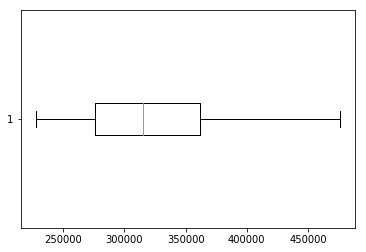

In [54]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 5, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 6

In [55]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 6, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

,Cluster Labels,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,Feb-2019 Median Home Value,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,6,55033,Hastings,44.726517,-92.86147,MN,Minneapolis-St. Paul-Bloomington,Dakota County,3355,261500,Pizza Place,Hotel,Pharmacy,Park,American Restaurant,Mexican Restaurant,Sandwich Place,Moving Target,German Restaurant,Sports Bar
28,6,55448,Coon Rapids,45.186232,-93.29635,MN,Minneapolis-St. Paul-Bloomington,Anoka County,3916,239900,Park,Moving Target,Video Store,Fast Food Restaurant,Sandwich Place,Miscellaneous Shop,Trail,Coffee Shop,Pet Store,Bridge
37,6,55076,Inver Grove Heights,44.844833,-93.03528,MN,Minneapolis-St. Paul-Bloomington,Dakota County,4936,238200,Pizza Place,Bar,Grocery Store,Discount Store,Park,Restaurant,Fast Food Restaurant,Music Venue,Bowling Alley,Liquor Store
42,6,55306,Burnsville,44.732569,-93.28909,MN,Minneapolis-St. Paul-Bloomington,Dakota County,6550,302900,Clothing Store,American Restaurant,Shoe Store,Lingerie Store,Department Store,Sushi Restaurant,Kids Store,Cocktail Bar,Gift Shop,Salon / Barbershop
56,6,55315,Carver,44.736595,-93.65619,MN,Minneapolis-St. Paul-Bloomington,Carver County,11406,341700,Construction & Landscaping,Scenic Lookout,Auto Workshop,Zoo Exhibit,Fish Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service


{'whiskers': [<matplotlib.lines.Line2D at 0x7f66d4369da0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f66d4373470>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f66d4369c50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f66d4373b00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f66d4373e48>],
 'means': []}

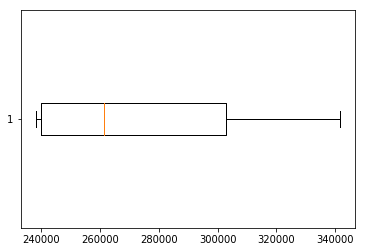

In [56]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 6, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 7

In [57]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 7, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

,Cluster Labels,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,Feb-2019 Median Home Value,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,7,55044,Lakeville,44.669564,-93.26654,MN,Minneapolis-St. Paul-Bloomington,Dakota County,779,352000,Department Store,Beach,Skating Rink,Disc Golf,Golf Course,Doctor's Office,Lake,Harbor / Marina,Zoo Exhibit,Financial or Legal Service
2,7,55337,Burnsville,44.770297,-93.27302,MN,Minneapolis-St. Paul-Bloomington,Dakota County,806,273500,Coffee Shop,Video Store,Home Service,Sandwich Place,Salon / Barbershop,Pizza Place,Hotel,Lighting Store,Music Venue,General Entertainment
5,7,55113,Roseville,45.011215,-93.15536,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,948,270900,Clothing Store,Coffee Shop,Shoe Store,Chinese Restaurant,Mobile Phone Shop,Italian Restaurant,Kids Store,Skating Rink,Park,Lingerie Store
9,7,55117,Saint Paul,44.989065,-93.10666,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,1475,213500,Fast Food Restaurant,Bar,Thai Restaurant,American Restaurant,Music Venue,Discount Store,Gas Station,Locksmith,Pharmacy,Liquor Store
12,7,55119,Saint Paul,44.957315,-93.00616,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,1687,212700,Fast Food Restaurant,Sandwich Place,Pizza Place,Chinese Restaurant,Thrift / Vintage Store,Park,Discount Store,Coffee Shop,Liquor Store,Burger Joint
33,7,55014,Lino Lakes,45.153516,-93.14463,MN,Minneapolis-St. Paul-Bloomington,Anoka County,4336,267900,American Restaurant,Pizza Place,Fast Food Restaurant,Fondue Restaurant,Video Store,Thrift / Vintage Store,Bar,Grocery Store,Big Box Store,Massage Studio
36,7,55129,Woodbury,44.896938,-92.90241,MN,Minneapolis-St. Paul-Bloomington,Washington County,4802,421000,Park,Bakery,Golf Course,American Restaurant,Food,Gym,Factory,Falafel Restaurant,Farm,Farmers Market
40,7,55317,Chanhassen,44.866236,-93.54487,MN,Minneapolis-St. Paul-Bloomington,Carver County,5565,390800,Sandwich Place,Pizza Place,American Restaurant,Liquor Store,Fast Food Restaurant,Coffee Shop,Video Store,Supermarket,Mexican Restaurant,Salon / Barbershop
43,7,55108,Saint Paul,44.982515,-93.17489,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,6716,290100,American Restaurant,Zoo Exhibit,Snack Place,Sandwich Place,Coffee Shop,Italian Restaurant,Art Gallery,Greek Restaurant,Pizza Place,Music Venue
50,7,55011,East Bethel,45.335128,-93.27434,MN,Minneapolis-St. Paul-Bloomington,Anoka County,8998,279100,Hardware Store,Zoo Exhibit,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Financial or Legal Service,Fish Market,Flower Shop


{'whiskers': [<matplotlib.lines.Line2D at 0x7f66d42c1710>,
 'caps': [<matplotlib.lines.Line2D at 0x7f66d42c1da0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f66d42c15c0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f66d42ca470>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f66d42ca7b8>],
 'means': []}

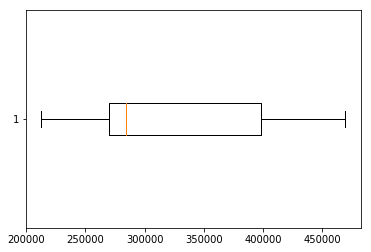

In [58]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 7, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 8

In [59]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 8, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

,Cluster Labels,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,Feb-2019 Median Home Value,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,8,55124,Apple Valley,44.743963,-93.20624,MN,Minneapolis-St. Paul-Bloomington,Dakota County,472,276800,Park,Coffee Shop,Asian Restaurant,Gym / Fitness Center,Convenience Store,Soccer Field,American Restaurant,Pizza Place,Mexican Restaurant,Mobile Phone Shop
11,8,55110,White Bear Lake,45.081266,-93.01146,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,1639,263200,Bar,American Restaurant,Wine Bar,Bakery,Pizza Place,Coffee Shop,ATM,Pub,Beach Bar,Salon / Barbershop


{'whiskers': [<matplotlib.lines.Line2D at 0x7f66d4299080>,
 'caps': [<matplotlib.lines.Line2D at 0x7f66d4299710>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f66d4291ef0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f66d4299da0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f66d42a3128>],
 'means': []}

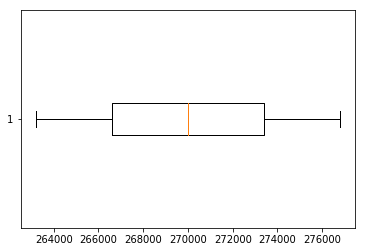

In [60]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 8, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

#### Cluster 9

In [61]:
MSP_merged.loc[MSP_merged['Cluster Labels'] == 9, MSP_merged.columns[list(range(0, MSP_merged.shape[1]))]]

,Cluster Labels,ZipCode,City,Latitude,Longitude,State,Metro,CountyName,SizeRank,Feb-2019 Median Home Value,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,9,55112,New Brighton,45.076365,-93.19335,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,1007,267700,Beach,Deli / Bodega,Furniture / Home Store,Park,Gym,Sandwich Place,Dive Bar,Playground,Factory,Intersection
10,9,55304,Andover,45.254715,-93.28652,MN,Minneapolis-St. Paul-Bloomington,Anoka County,1544,316100,Park,Pub,Eye Doctor,Construction & Landscaping,Restaurant,Financial or Legal Service,Factory,Falafel Restaurant,Farm,Farmers Market
16,9,55109,Maplewood,45.010632,-93.01845,MN,Minneapolis-St. Paul-Bloomington,Ramsey County,2549,233600,Sandwich Place,Gym / Fitness Center,Baseball Field,Shipping Store,Fast Food Restaurant,Park,Pizza Place,Convenience Store,Mexican Restaurant,Korean Restaurant
31,9,55068,Rosemount,44.732105,-93.13437,MN,Minneapolis-St. Paul-Bloomington,Dakota County,4004,281500,Pizza Place,Fast Food Restaurant,Liquor Store,Pet Store,Grocery Store,Bar,American Restaurant,Coffee Shop,Salon / Barbershop,Sandwich Place
48,9,55121,Eagan,44.844965,-93.14431,MN,Minneapolis-St. Paul-Bloomington,Dakota County,8500,259800,Sandwich Place,American Restaurant,Hotel,Coffee Shop,Fast Food Restaurant,Mobile Phone Shop,Pizza Place,Chinese Restaurant,Furniture / Home Store,Business Service
54,9,55071,Saint Paul Park,44.835366,-92.99254,MN,Minneapolis-St. Paul-Bloomington,Washington County,11002,221200,Bar,Baseball Field,Harbor / Marina,Sports Bar,Home Service,Pizza Place,Bowling Alley,Park,Falafel Restaurant,Farm
57,9,55120,Mendota Heights,44.873398,-93.14538,MN,Minneapolis-St. Paul-Bloomington,Dakota County,11854,379700,Baseball Field,Hotel,Insurance Office,Intersection,American Restaurant,Business Service,Soccer Field,Construction & Landscaping,Golf Course,Lake


{'whiskers': [<matplotlib.lines.Line2D at 0x7f66d426be80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f66d41f7550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f66d426bd30>],
 'medians': [<matplotlib.lines.Line2D at 0x7f66d41f7be0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f66d41f7f28>],
 'means': []}

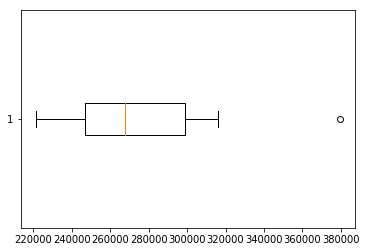

In [62]:
x = MSP_merged.loc[MSP_merged['Cluster Labels'] == 9, MSP_merged.columns[9]]
#sns.distplot(x)
plt.boxplot(x, vert=False)

## Calculate 5 year CAGR and use data for choropleth map

In [65]:
zill_MSP_df.shape

(72, 70)

### geoJSON visual section

In [66]:
#zill_MSP_df.loc[0,zill_MSP_df.columns[[0] + [9]]]

import zipcode geojson data for MN from this site; use to make choropleth maps etc.; https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/README.md

In [63]:
mn_zipcode_file = open('mn_minnesota_zip_codes_geo.json')
mn_zipcode_str = mn_zipcode_file.read()
mn_zipcode_data = json.loads(mn_zipcode_str)

Write smaller geojson for just 7 county area from full MN zipcode geojson

In [341]:
#type(mn_zipcode_data)
#for postcode in MSP_merged['ZipCode']:
#    print(postcode)

# figure out how to read element [0] into a string then dump it to a json
#MN_geoJSON_temp = mn_zipcode_data['features'][0]

#MN_geoJSON_temp = {}
#MN_geoJSON_temp.setdefault(1,mn_zipcode_data['features'][1])
#MN_geoJSON_temp[1]['properties']['ZCTA5CE10']
#del MN_geoJSON_temp


#MSP_geoJSON = {'type': 'FeatureCollection'}   # dict to store matches
#MSP_geoJSON.setdefault('features', dict())
#MSP_geoJSON

#mn_zipcode_data['features'][0]

In [117]:
#features = list(MSP_geoJSON_temp.keys())
#features = [1, 2]
#MSP_geoJSON = {'type' : 'FeatureCollection', 'features' : []}
#MSP_geoJSON = {'type' : 'FeatureCollection', 'features' : features}
#mn_zipcode_data['features'][0].keys()
#MSP_geoJSON['features'][0]['properties']
#elem

In [118]:
elem = 0 # use to count how many elements
# dict to store matches; Note previously had { ... 'features' : dict()} which made features keys vs items as they are now with []
MSP_geoJSON = {'type': 'FeatureCollection', 'features' : []}

# loop through all the elements in the larger JSON file (which is now stored as a python dict); there is an element for each zipcode in MN
for element in mn_zipcode_data['features']:
    # loop through each zipcode element and look for the property where the zipcode is stored
    for k, v in element['properties'].items():
        if k == 'ZCTA5CE10':
            # loop through each zipcode in MSP_merged dataset
            for postcode in MSP_merged['ZipCode']:
                # if the current value from the larger JSON file matches it a zipcode in MSP_merged add the element to MN_geoJSON dict and incr elem
                if str(v) == str(postcode):
                    MSP_geoJSON['features'].append(mn_zipcode_data['features'][elem])
                    elem += 1    # increment the element count to keep track of how many elements

In [74]:
#zipcode0 = dict(mn_zipcode_data['features'][0])
#zipcode0['type']
#mn_zipcode_data = mn_zipcode_data['features']
#mn_zipcode_data['features'][0]['properties']['ZCTA5CE10']

In [119]:
# write MSP_geoJSON to msp_zipcode_geo.json file
with open('msp_zipcode_geo.json', 'w') as oufile:
    json.dump(MSP_geoJSON, oufile)

In [120]:
#MSP_geoJSON

#msp_zipcode_geo = r'msp_zipcode_geo.json'

#with open('msp_zipcode_geo.json') as infile:
#    msp_zipcode_geo = json.loads(infile.read())
#msp_zipcode_geo

mn_zipcode_geo = r'mn_minnesota_zip_codes_geo.json'

In [129]:
# create a map of minneapolis-st.paul metro area
msp_map = folium.Map(location=[latitude, longitude], zoom_start=9)

# this works with full mn_zipcode_geo file but takes forever to load; so even though my subset looks the same it's not!
#folium.GeoJson(
#    msp_zipcode_geo,
#    name='geojson'
#).add_to(msp_map)

msp_map

In [123]:
#test_set = MSP_merged[['ZipCode','Feb-2019 Median Home Value']].copy(deep=True)
#del test_set
#test_set.head()
#for pc_l in test_set:
#    for k, v in 
#    MSP_geoJSON['features'][0][]

#    print(postcode)

In [124]:
# generate choropleth map using Feb 2019 median home value by zipcode
msp_map.choropleth(
    geo_data=msp_zipcode_geo,
    data=MSP_merged,
    columns=['ZipCode', 'Feb-2019 Median Home Value'],
    key_on='features.properties.ZCTA5CE10',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='ZipCode'
)

# display map
msp_map

AttributeError: 'NoneType' object has no attribute 'get'